Theodoros Kassa Aragie

251163893

ECE 9309

Prof. Soodeh Nikan

February 17, 2025

# Implementing Agglomerative Clustering for a Recommender System

Dataset 1: https://www.kaggle.com/datasets/pushkaranp/ieee-research-papers-dataset?resource=download

In [1]:
# Misc Imports
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# SciKit-Learn Imports
from sklearn.cluster import AgglomerativeClustering 
# from sklearn.preprocessing import StandardScaler 
import scipy.cluster.hierarchy as shc 
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer

## Load Splitted Data

In [ ]:
# Load in the preprocessed dataset splits
trnDF:pd.DataFrame = pd.read_parquet("./parquets/train.parquet.gzip")
tstDF:pd.DataFrame = pd.read_parquet("./parquets/test.parquet.gzip")
valDF:pd.DataFrame = pd.read_parquet("./parquets/val.parquet.gzip")
cleanedDF:pd.DataFrame = pd.read_parquet("./parquets/cleaned.parquet.gzip")

## Visualize Data and Determine the Best n_clusters for Agglomerative Clustering

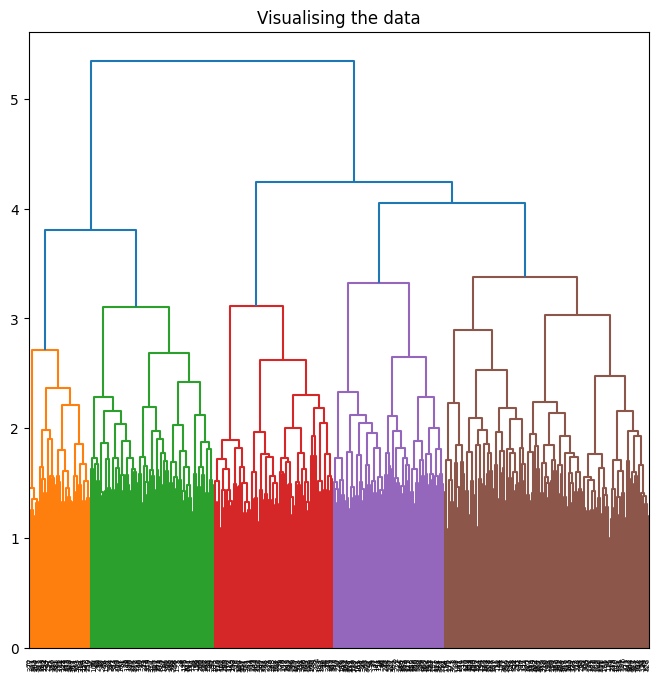

In [3]:
# Dendrogram
plt.figure(figsize =(8, 8)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(trnDF, method ='ward')))

[2, 3, 4, 5, 6]


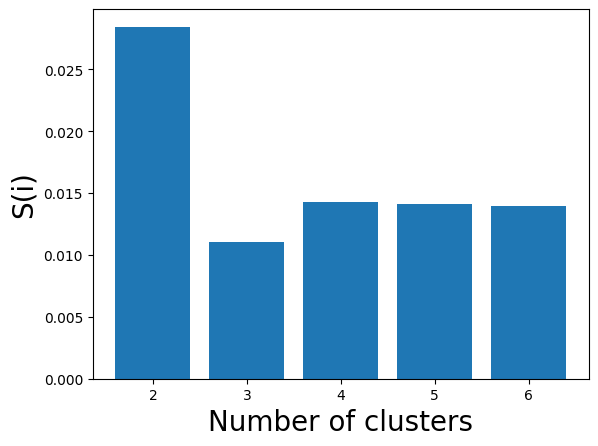

In [4]:
# Use silhouette scores to assess the best AC
# (AgglomerativeClustering) n_clusters value
kVals:list[int] = [i for i in range(2, 7)]
print(kVals)

silhScores:list = [
    silhouette_score(
        trnDF,
        AgglomerativeClustering(n_clusters=i).fit_predict(trnDF)
    ) for i in kVals
]

# Plotting a bar graph to compare the results 
plt.bar(kVals, silhScores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show()

In [5]:
# Calculate labels using optimal AC clusters
bestAC:AgglomerativeClustering = AgglomerativeClustering(n_clusters=2)
trnLabels = bestAC.fit_predict(trnDF)
trnDF["cluster"] = trnLabels
tstLabels = bestAC.fit_predict(tstDF)
tstDF["cluster"] = tstLabels

## Make Recomendations, Cosine Similarity, Save Model

In [ ]:
# Function to recommend top n papers (default to top_n=10)
def recommendPapers(testPaperIndex:int, top_n:int=10):
    testPaperClusters:pd.DataFrame = tstDF.iloc[
        testPaperIndex
    ]["cluster"]
    # Get all training papers in the same cluster
    sameClusterPapers:pd.DataFrame = trnDF[
        trnDF["cluster"] == testPaperClusters
    ]
    # Ensure index alignment before selecting embeddings
    sameClusterIndices:pd.Index = sameClusterPapers.index.intersection(
        trnDF.index
    )
    # Get appropriate vectors
    testEmbeddings:npt.NDArray = tstDF.iloc[
        testPaperIndex
    ].values.reshape(1, -1)
    trainEmbeddings:npt.NDArray = trnDF.loc[
        sameClusterIndices
    ].values  # Exclude cluster column
    # Compute the distances between points
    distances:npt.NDArray = euclidean_distances(testEmbeddings, trainEmbeddings)[0]
    # Get top-N most similar papers, highest similarity first
    topIndices:npt.NDArray = np.argsort(distances)[-top_n:][::-1]
    topPapers:list[int] = sorted(sameClusterIndices[topIndices].to_list())
    topEmbeddings:npt.NDArray = trnDF.iloc[topIndices].values
    # Compute cosine similarity
    similarities:npt.NDArray = cosine_similarity(
        testEmbeddings, topEmbeddings
    ) 
    return similarities, topPapers

# Example usage
testSims, topRecommendations = recommendPapers(0, top_n=10)
print(cleanedDF.iloc[topRecommendations])

                                                 title                link  \
1    The Use of Tangible User Interfaces in K12 Edu...  /document/9721879/   
43   The Effect of Stakeholders’ Satisfaction and P...  /document/8911308/   
45   A Hybrid Scheduling Mechanism Based on Agent C...  /document/9300134/   
65   Correction to “Tear-and-Interconnect Domain De...  /document/9296601/   
67   Privacy Protection for Telecare Medicine Infor...  /document/8930560/   
116  Correction to “A Novel Unbalance Compensation ...  /document/8924965/   
128  Concentration and Spatial Clustering of Forest...  /document/9284480/   
239  A Comprehensive Study of the IoT Cybersecurity...  /document/9303356/   
364  xCorrection to “Classification of Poetry Text ...  /document/9299426/   
450  vMobiDesk: Desktop Virtualization for Mobile O...  /document/9277517/   

     year                                            authors  citations  \
1    2022  ['José A. Gallud', 'Ricardo Tesoriero', 'Maria...      

In [7]:
# Print out cosine similarity score matrix:
print(testSims)

# Compute average similarity score per test sample
avgTestScore:npt.NDArray = testSims.mean(axis=1)

# Overall similarity score
avgTestSim:npt.NDArray = avgTestScore.mean()
print(f"\nAverage Cosine Similarity Score for Test Set: {avgTestSim}")

# Save the trained model
joblib.dump(bestAC, "./dump/acModel.pkl")

[[0.23180166 0.41851364 0.3278039  0.25929563 0.30756922 0.29933976
  0.3063819  0.39970772 0.2241992  0.20762676]]

Average Cosine Similarity Score for Test Set: 0.2982239381258889


['./dump/acModel.pkl']

In [8]:
# Reload the model
loadedModel:AgglomerativeClustering = joblib.load("./dump/acModel.pkl")
valLabels = loadedModel.fit_predict(valDF)
valDF["cluster"] = valLabels

In [ ]:
# Function to recommend top n papers (default to top_n=10)
def selectPapers(valPaperIndex:int, top_n:int=10):
    valPaperClusters:pd.DataFrame = valDF.iloc[
        valPaperIndex
    ]["cluster"]
    # Get all training papers in the same cluster
    sameClusterPapers:pd.DataFrame = trnDF[
        trnDF["cluster"] == valPaperClusters
    ]
    # Ensure index alignment before selecting embeddings
    sameClusterIndices:pd.Index = sameClusterPapers.index.intersection(
        trnDF.index
    )
    # Get appropriate vectors
    valEmbeddings:npt.NDArray = valDF.iloc[
        valPaperIndex
    ].values.reshape(1, -1)
    trainEmbeddings:npt.NDArray = trnDF.loc[
        sameClusterIndices
    ].values  # Exclude cluster column
    # Compute the distances between points
    distances:npt.NDArray = euclidean_distances(valEmbeddings, trainEmbeddings)[0]
    # Get top-N most similar papers, highest similarity first
    topIndices:npt.NDArray = np.argsort(distances)[-top_n:][::-1]
    topPapers:list[int] = sorted(sameClusterIndices[topIndices].to_list())
    topEmbeddings:npt.NDArray = trnDF.iloc[topIndices].values
    # Compute cosine similarity
    similarities:npt.NDArray = cosine_similarity(
        valEmbeddings, topEmbeddings
    ) 
    return similarities, topPapers

# Test on new papers
valSims, topSelections = selectPapers(0, top_n=10)
print(cleanedDF.iloc[topSelections])

                                                 title                link  \
43   The Effect of Stakeholders’ Satisfaction and P...  /document/8911308/   
102  Critical Challenges to Adopt DevOps Culture in...  /document/9690862/   
116  Correction to “A Novel Unbalance Compensation ...  /document/8924965/   
179  Trapdoor Privacy in Public Key Encryption With...  /document/9713888/   
293  Towards a Self-Driving Management System for t...  /document/9625012/   
327  An Accurate Matching Query Method of Natural L...  /document/9722935/   
358  How Does Proximity Affect the Dual Innovation ...  /document/9709769/   
364  xCorrection to “Classification of Poetry Text ...  /document/9299426/   
487  Promotion Pathways of Financial Performance: A...  /document/9684747/   
534  Enabling Identity for the IoT-as-a-Service Bus...  /document/9627693/   

     year                                            authors  citations  \
43   2019  ['Sanderson C. M. Barbalho', 'José Carlos De T...      

In [10]:
# Print out cosine similarity score matrix
print(valSims)

# Compute average similarity score per validation sample
avgValScore:npt.NDArray = valSims.mean(axis=1)

# Overall similarity score
avgValSim:npt.NDArray = avgValScore.mean()
print(f"\nAverage Cosine Similarity Score for Validation Set: {avgValSim}")

[[0.38131159 0.22748053 0.22014962 0.27052689 0.27420824 0.2743123
  0.33113884 0.27737638 0.2368193  0.22744027]]

Average Cosine Similarity Score for Validation Set: 0.2720763967132217


## TF-IDF and Feature Importance Plot

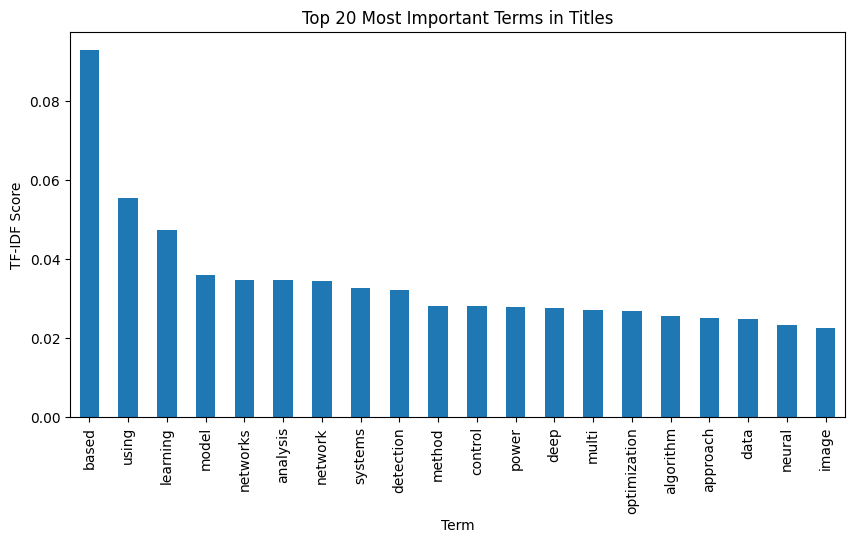

In [11]:
# Convert titles into TF-IDF representation
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = vectorizer.fit_transform(cleanedDF["title"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out()
)

# Plot top 20 TF-IDF terms
tfidf_df.mean().nlargest(20).plot(kind='bar', figsize=(10, 5))
plt.title("Top 20 Most Important Terms in Titles")
plt.xlabel("Term")
plt.ylabel("TF-IDF Score")
plt.show()